In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.signal import medfilt

data = pickle.load(open('QM3hystscan_2022_01_18.pkl','rb'))

In [16]:
data.keys()
current = data['L1:RG2:QM3:CurrentAO']
beam_charge = data['L1:CM2:measCurrentCM']
beam_charge_smooth = medfilt(beam_charge[1],21)
#beam_charge_smooth = beam_charge[1]
print(len(beam_charge_smooth))

11211


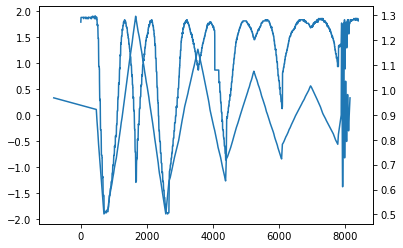

In [17]:
fig,ax = plt.subplots()
ax.plot(*current)
ax2 = ax.twinx()
ax2.plot(beam_charge[0], beam_charge_smooth)

(698, 2)


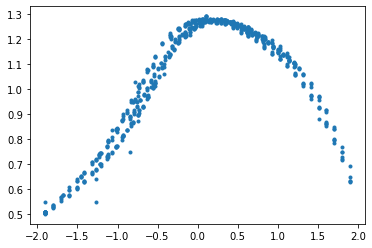

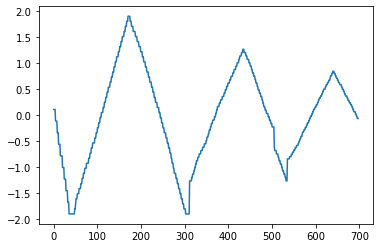

In [18]:

# bin measured current based on timestamps for current read back
timestamps = current[0][1:-200]
currents = current[1][1:-200]
beam_charge_binned = []
for i in range(len(timestamps)-1):
    beam_charge_binned += [beam_charge_smooth[np.argwhere(
        (beam_charge[0] > timestamps[i]) & (beam_charge[0] < timestamps[i+1])
    )]]

beam_charge_full = []
for i in range(len(currents)-1):
    for ele in beam_charge_binned[i]:
        beam_charge_full += [[currents[i], ele]]
beam_charge_full = np.asfarray(beam_charge_full)[::10]
print(beam_charge_full.shape)
fig, ax = plt.subplots()
ax.plot(*beam_charge_full.T,'.')

fig2,ax2 = plt.subplots()
ax2.plot(beam_charge_full.T[0])

(229,)


C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

<ErrorbarContainer object of 3 artists>

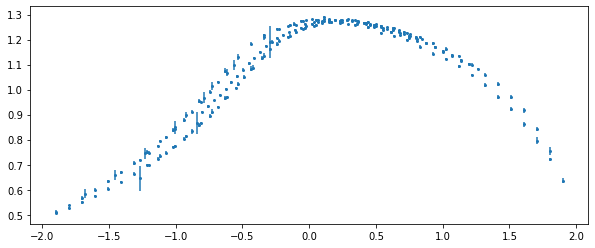

In [19]:
beam_charge_mean = np.array([np.mean(ele) for ele in beam_charge_binned])
beam_charge_std = np.array([np.std(ele) for ele in beam_charge_binned])
print(currents.shape)

fig,ax = plt.subplots()
fig.set_size_inches(10,4)
ax.errorbar(currents[:-1], beam_charge_mean, beam_charge_std,fmt='o', ms=2)

In [20]:
from gpytorch import ExactMarginalLogLikelihood
from hysteresis.hybrid import ExactHybridGP
from hysteresis.base import BaseHysteresis
import torch

# clean up data that has nans - (measurements not taken during timestep)
train_y = beam_charge_mean[np.argwhere(~np.isnan(beam_charge_mean))][:250]
train_x = currents[:-1][np.argwhere(~np.isnan(beam_charge_mean))][:250]

#train_x = beam_charge_full[:,0]
#train_y = beam_charge_full[:,1]

# set up training data for joint hysteresis model
train_x = torch.tensor(train_x).double().reshape(-1,1)
train_y = torch.tensor(train_y).double()

In [21]:
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from botorch.models import SingleTaskGP

#create normal GP model
gp = SingleTaskGP(
    train_x,
    train_y,
    likelihood=FixedNoiseGaussianLikelihood(
        torch.zeros_like(train_x),
        learn_additional_noise=True
    )
)
gp_mll = ExactMarginalLogLikelihood(gp.likelihood, gp)


In [22]:
from botorch import fit_gpytorch_model

gp_res = fit_gpytorch_model(gp_mll, max_retries=10)

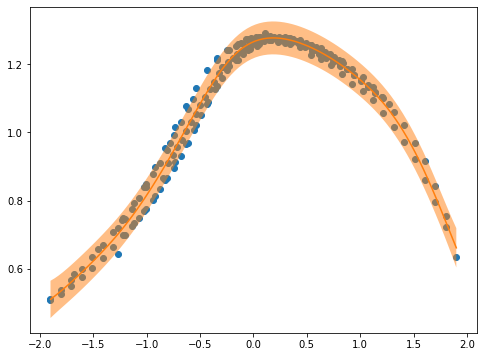

In [25]:
# compare GP model to hybrid model
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

test_x = torch.linspace(torch.min(train_x), torch.max(train_x),100).double()
with torch.no_grad():
    gp_post = gp.likelihood(gp(test_x))
    gp_mean = gp_post.mean
    gp_l, gp_u = gp_post.confidence_region()

ax.plot(train_x, train_y, 'o')
ax.plot(test_x, gp_mean,zorder=10)
ax.fill_between(test_x, gp_l, gp_u, alpha=0.5,fc='C1',zorder=9)



In [24]:
for name,val in gp.named_parameters():
    print(f'{name}:{val}')

likelihood.second_noise_covar.raw_noise:Parameter containing:
tensor([-7.6761], dtype=torch.float64, requires_grad=True)
mean_module.constant:Parameter containing:
tensor([0.5937], dtype=torch.float64, requires_grad=True)
covar_module.raw_outputscale:-1.8011101076885785
covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[1.4447]], dtype=torch.float64, requires_grad=True)
